In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#@njit(nopython=False)
def grid_to_image(latitude, longitude, QOI, hour, max_shape=256, mode="mean", verbose=True):
    # Verbose
    if verbose:
        print(f"Generating {mode} Image of water level...")

    lat_m, lat_M = latitude.min(), latitude.max()
    lon_m, lon_M = longitude.min(), longitude.max()

    delta_x = (lat_M - lat_m) / max_shape
    delta_y = (lon_M - lon_m) / max_shape
    delta = max(delta_x, delta_y)

    if verbose:
        print(f"Latitude: {lat_m, lat_M}.")
        print(f"Longitude: {lon_m, lon_M}.")
        print(f"Res: {delta:0.4f}.")

    nx, ny = int(np.ceil((lat_M - lat_m)/delta)), int(np.ceil((lon_M - lon_m)/delta))

    coarse_image = np.zeros((nx, ny))
    for i in range(nx):
        for j in range(ny):
            cropped_latitude_id = np.where((latitude > lat_m + i*delta) & (latitude < lat_m + (i+1)*delta))
            cropped_longitude_id = np.where((longitude > lon_m + j*delta) & (longitude < lon_m + (j+1)*delta))
            cropped_id = np.intersect1d(cropped_latitude_id, cropped_longitude_id)

            if len(cropped_id) == 0:
                coarse_image[i, j] = 0
            
            else:
                cropped_QOI = QOI[hour, cropped_id]

                if mode.lower() == "mean":
                    coarse_image[i, j] = cropped_QOI.mean()
                elif mode.lower() == "std":
                    coarse_image[i, j] = cropped_QOI.std()
                elif mode.lower() == "minmax":
                    coarse_image[i, j] = cropped_QOI.max() - cropped_QOI.min()
                else:
                    raise NotImplementedError

        if verbose:
            print(f"Processing... {(i+1)/nx * 100:0.3f}%", end="\r")
    #print("")

    coarse_image = np.flipud(coarse_image)
    return coarse_image
#@njit(nopython=False)
def find_closest_nonzero(matrix, zero_coords):
    nonzero_coords = np.transpose(np.nonzero(matrix))
    distances = np.linalg.norm(nonzero_coords - zero_coords, axis=1)
    closest_nonzero_index = np.argmin(distances)
    closest_nonzero_coords = tuple(nonzero_coords[closest_nonzero_index])
    return closest_nonzero_coords

In [3]:
# Load file
f = h5py.File("/home/faster/Documents/approximating_shefem/na-bcera5_381-419.mat")

In [4]:
# Load QOI (Water Level) 
# WARNING: Takes some time!!!
wl = np.asarray(f["S"]['wl'])
wl.shape

(28056, 37111)

In [5]:
# Loading other informations from f
lat = np.asarray(f["S"]['lat'])[0]
lon = np.asarray(f["S"]['lon'])[0]
time = np.asarray(f["S"]['tvec'])

print(f"Shapes -> Lat: {lat.shape}, Lon: {lon.shape}, Time: {time.shape}.")

Shapes -> Lat: (37111,), Lon: (37111,), Time: (6, 28056).


In [6]:
# Process  time
idx_2011 = np.where(time[0] == 2019)[0]
time = time.T[idx_2011].T
print(time.shape)

(6, 8760)


In [7]:
# Process QOI
wl = wl[idx_2011, :]
print(f"Shape QOI: {wl.shape}.")

Shape QOI: (8760, 37111).


In [8]:
# Load sea mask
sea_mask = np.load('sea_mask.npy')
print(sea_mask.shape)

(130, 256)


In [9]:
import numpy as np
import concurrent.futures

# Assuming definitions of grid_to_image, lat, lon, wl, sea_mask are available

def process_hour(k):

    #print(lat.shape)
    coarse_image = grid_to_image(lat, lon, wl, hour=k, max_shape=256, mode="mean", verbose=False)
    nx, ny = coarse_image.shape
    nonzero_coords = np.transpose(np.nonzero(coarse_image))
    closest_indices = np.ones((4,), dtype=np.int32)  # Moved inside the function to avoid shared state issues
    

    for i in range(nx):
        for j in range(ny):
            x = coarse_image[i, j]
            if x < 1e-10 and sea_mask[i, j] == 1:
                distances = np.linalg.norm(nonzero_coords - np.array([[i, j]]), axis=1)

                for l in range(4):
                    index = np.argmin(distances)
                    closest_indices[l] = index
                    distances[index] = 256

                closest_coordinates = [tuple(nonzero_coords[i]) for i in closest_indices]
                temp = 0
                for s in range(len(closest_coordinates)):
                    temp += coarse_image[closest_coordinates[s]]
                coarse_image[i, j] = temp / len(closest_coordinates)
    return k, coarse_image

In [10]:
from multiprocessing import Pool, cpu_count
times = []

def multi():
    num_hours = 8760  # Adjust as needed
    # Assuming the shape is (8760, 130, 256) for demonstration purposes
    accumulator = np.zeros((num_hours, 130, 256), dtype=np.float32)

    # Use as many processes as there are CPUs available
    with Pool(processes=cpu_count()) as pool:
        results = pool.map(process_hour, range(num_hours))

    # Accumulate results
    for j, result in enumerate(results):
        if result is not None:
            accumulator[j] = result[1]
            times.append(result[0])
        p = (j+1)/num_hours*100
        print(f"Percentage completed: {p:0.3f}%", end="\r")

    # Now you can use 'accumulator' as needed
    print("\nAll operations completed.")
    return accumulator 

In [ ]:
import time 
st = time.time()
accumulator = multi()
print(time.time() - st) 

In [14]:
accumulator.shape

(6191, 130, 256)

In [15]:
np.save("processed_data/seconda_parte2018_images.npy",accumulator)

In [35]:
arra = np.array(times)

In [36]:
arra.shape

(8760, 130, 256)

In [47]:
test = np.load("processed_data/2011_images.npy")

In [50]:
np.save("2011_images", test.astype(np.float32))

In [46]:
test.dtype

dtype('float64')

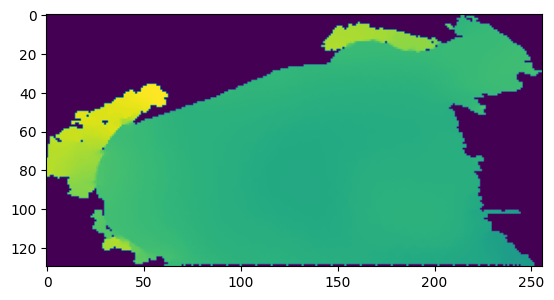

In [22]:
plt.imshow(times[100])

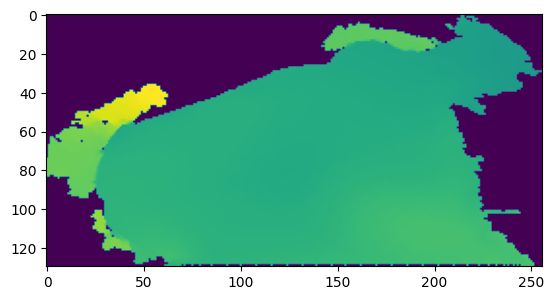

In [31]:
plt.imshow(accumulator[3] - )

In [ ]:
accumulator = np.zeros((8760,130,256))
closest_indices = np.ones((4,), dtype=np.int32)
for k in range(8760):
    # Generate image from the grid
    coarse_image = grid_to_image(lat, lon, wl, hour=k, max_shape=256, mode="mean", verbose=False)
    nx, ny = coarse_image.shape
    #print(f"Done! Shape: {nx, ny}.")
    # Interpolate zero-valued pixels inside the mask
    nonzero_coords = np.transpose(np.nonzero(coarse_image))
    for i in range(nx):
        for j in range(ny):
            x = coarse_image[i, j]
    
            # Interpolate only if its value is 0
            if x < 1e-10 and sea_mask[i, j] == 1:
                distances = np.linalg.norm(nonzero_coords - np.array([[i, j]]), axis=1)

                for l in range(4):
                    index = np.argmin(distances)
                    closest_indices[l] = index
                    distances[index] = 256
                    
                #closest_indices = np.argsort(distances)[:4]
                #print(closest_indices)
                closest_coordinates = [tuple(nonzero_coords[i]) for i in closest_indices]
    
                temp = 0
                for s in range(len(closest_coordinates)):
                    temp += coarse_image[closest_coordinates[s]]
                coarse_image[i, j] = temp / len(closest_coordinates)

    accumulator[k] = coarse_image
    p = (k+1)/8760*100
    #print(p)
    print(f"perc: {p:0.3f}%",end="\r")